# Model GARCH

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import datetime, timedelta

In [5]:
#import the dataset
btc_aud_df=pd.read_csv("btc_aud_tout.csv")
#convert the type of "dates" into datetime
btc_aud_df["dates"]=pd.to_datetime(btc_aud_df["dates"])
#verify the value in the column "dates" : Timestamp
type(btc_aud_df.iloc[0,0])

pandas._libs.tslibs.timestamps.Timestamp

In [6]:
#a glimpse of the dataset
btc_aud_df.shape #(14841, 5)
btc_aud_df.head()


,dates,open,high,low,close
0,2019-02-08 01:00:00,4734.00,4750.35,4728.38,4750.35
1,2019-02-08 02:00:00,4750.35,4752.67,4746.09,4746.09
2,2019-02-08 03:00:00,4746.09,4746.09,4738.71,4746.09
3,2019-02-08 04:00:00,4751.37,4764.53,4751.37,4759.97
4,2019-02-08 05:00:00,4759.85,4761.55,4743.09,4761.54


In [7]:
#add some columns into the dataframe btc_aud_df : "returns", "log_returns","log_close","returns_scale_100", "log_returns_scale_100"
#returns
btc_aud_df["returns"]=btc_aud_df.close.pct_change().dropna()
#log_close
btc_aud_df["log_close"]=np.log(btc_aud_df.close) #what's the difference between df.close et df["close"]
#log_returns
btc_aud_df["log_returns"]=btc_aud_df["log_close"]-btc_aud_df["log_close"].shift(1)

# in the ARCH package in python, we scale up the returns and log_returns for avoiding the convergence issues
#returns_scale_100
btc_aud_df["returns_scale_100"]=100*btc_aud_df["returns"]
#log_returns_scale_100
btc_aud_df["log_returns_scale_100"]=100*btc_aud_df["log_returns"]

In [8]:
#a glimpse of the dataframe
btc_aud_df.head()

,dates,open,high,low,close,returns,log_close,log_returns,returns_scale_100,log_returns_scale_100
0,2019-02-08 01:00:00,4734.00,4750.35,4728.38,4750.35,NaN,8.465974,NaN,NaN,NaN
1,2019-02-08 02:00:00,4750.35,4752.67,4746.09,4746.09,-0.000897,8.465076,-0.000897,-0.089678,-0.089718
2,2019-02-08 03:00:00,4746.09,4746.09,4738.71,4746.09,0.000000,8.465076,0.000000,0.000000,0.000000
3,2019-02-08 04:00:00,4751.37,4764.53,4751.37,4759.97,0.002925,8.467997,0.002920,0.292451,0.292024
4,2019-02-08 05:00:00,4759.85,4761.55,4743.09,4761.54,0.000330,8.468326,0.000330,0.032983,0.032978


In [9]:
#set the "dates" as the row index
btc_aud_df=btc_aud_df.set_index("dates")

In [10]:
btc_aud_df.head()

,open,high,low,close,returns,log_close,log_returns,returns_scale_100,log_returns_scale_100
dates,,,,,,,,,
2019-02-08 01:00:00,4734.00,4750.35,4728.38,4750.35,NaN,8.465974,NaN,NaN,NaN
2019-02-08 02:00:00,4750.35,4752.67,4746.09,4746.09,-0.000897,8.465076,-0.000897,-0.089678,-0.089718
2019-02-08 03:00:00,4746.09,4746.09,4738.71,4746.09,0.000000,8.465076,0.000000,0.000000,0.000000
2019-02-08 04:00:00,4751.37,4764.53,4751.37,4759.97,0.002925,8.467997,0.002920,0.292451,0.292024
2019-02-08 05:00:00,4759.85,4761.55,4743.09,4761.54,0.000330,8.468326,0.000330,0.032983,0.032978


## Variance / volatility

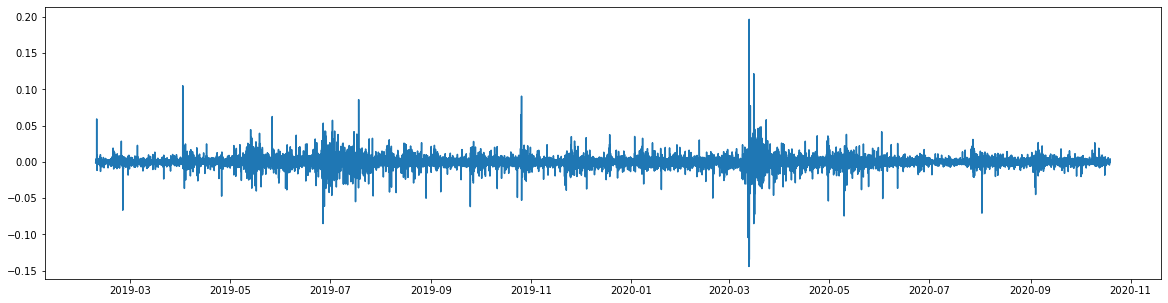

In [11]:
#log_returns
plt.figure(figsize=(20,5))
plt.plot(btc_aud_df["log_returns"]);

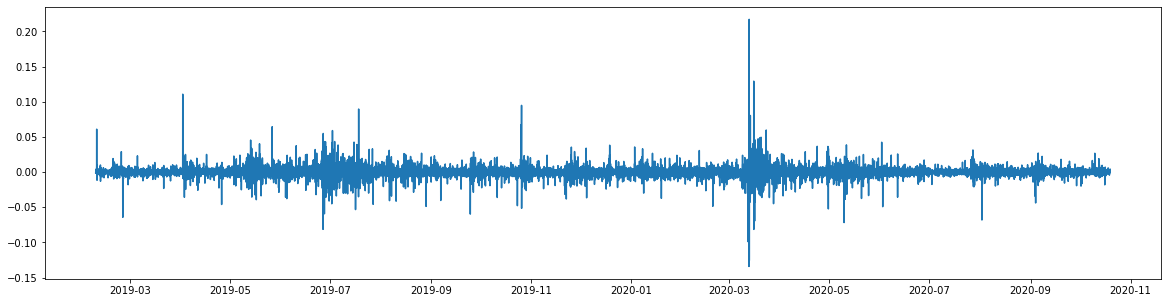

In [12]:
#simple returns
plt.figure(figsize=(20,5))
plt.plot(btc_aud_df["returns"]);
#we can see that the percent change of close price from one day to the next. It is a good candidate for the GARCH process
#because for some periods there are much higher volatility than other periods.
#once we choose GARCH as the model, we will proceed to obtain the (p,q)

In [13]:
#We would like to narrow the timestamps to see more clearly the volatility
#So we choose the period from 2020-03-01 to 2020-03-10
btc_aud_df_period=btc_aud_df.loc["2020-03-01 01:00:00" : "2020-03-10 23:00:00", "returns"]

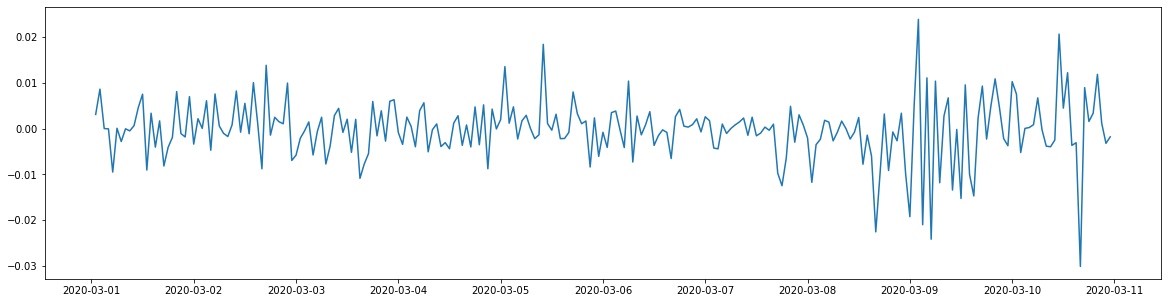

In [14]:
#plot the narrowed period
plt.figure(figsize=(20,5))
plt.plot(btc_aud_df_period);

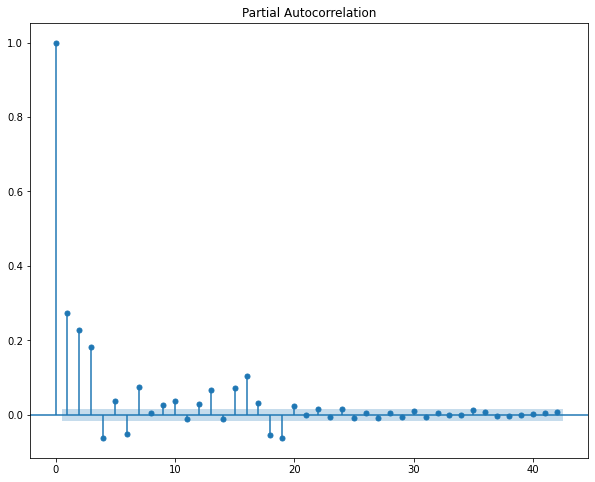

In [15]:
#try to figure out the (p,q) by plotting the PACF
squared_returns=(btc_aud_df["returns"]**2).dropna().values#plot_pacf() function condition: array and non Nan type
#plot_pacf(squared_returns);
#use plt.rc_context to temporarily set the default figsize before plotting.
with plt.rc_context():
    plt.rc("figure", figsize=(10,8))
    plot_pacf(squared_returns)


In [16]:
#GARCH(3,3)
returns=btc_aud_df["returns_scale_100"].dropna().reset_index(drop=True)#to have the ndarray type and delete the Nan value
btc_aud_model=arch_model(returns,p=3,q=3)
#fit
btc_aud_model_fit=btc_aud_model.fit()

Iteration:      1,   Func. Count:     10,   Neg. LLF: 120199.25650571825
Iteration:      2,   Func. Count:     25,   Neg. LLF: 63564.56681420625
Iteration:      3,   Func. Count:     39,   Neg. LLF: 22023.032520269357
Iteration:      4,   Func. Count:     49,   Neg. LLF: 21345.804725687463
Iteration:      5,   Func. Count:     60,   Neg. LLF: 14919.59636499979
Iteration:      6,   Func. Count:     70,   Neg. LLF: 14088.727850332152
Iteration:      7,   Func. Count:     80,   Neg. LLF: 15892.657357467722
Iteration:      8,   Func. Count:     90,   Neg. LLF: 14078.89315183364
Iteration:      9,   Func. Count:    100,   Neg. LLF: 13962.852328433235
Iteration:     10,   Func. Count:    109,   Neg. LLF: 13980.162634921006
Iteration:     11,   Func. Count:    119,   Neg. LLF: 14323.956586964265
Iteration:     12,   Func. Count:    129,   Neg. LLF: 13954.119575341017
Iteration:     13,   Func. Count:    138,   Neg. LLF: 13954.028257374572
Iteration:     14,   Func. Count:    147,   Neg. LLF: 

In [17]:
#get a global view
btc_aud_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:      returns_scale_100   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -13954.0
Distribution:                  Normal   AIC:                           27924.0
Method:            Maximum Likelihood   BIC:                           27984.9
                                        No. Observations:                14840
Date:                Wed, Dec 09 2020   Df Residuals:                    14832
Time:                        10:28:35   Df Model:                            8
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -2.2842e-03  8.720e-03     -0.262      0.793 [-1.938e-02,1.481e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0331  2.282e-02      1.449      0.147 [-1.167e-02,7.780e-02]
alpha[1]       0.1945  4.935e-02      3.941  8.122e-05    [9.774e-02,  0.291]
alpha[2]       0.1180      0.392      0.301      0.763      [ -0.649,  0.885]
alpha[3]   5.1680e-11      0.199  2.603e-10      1.000      [ -0.389,  0.389]
beta[1]        0.0000      1.334      0.000      1.000      [ -2.614,  2.614]
beta[2]        0.2523      1.383      0.182      0.855      [ -2.458,  2.963]
beta[3]        0.4198      0.337      1.246      0.213      [ -0.241,  1.080]
=============================================================================

Covariance estimator: robust
"""

In [18]:
#Garch(1,0)=ARCH(1)

btc_aud_model=arch_model(returns,p=1,q=0)
#fit
btc_aud_model_fit=btc_aud_model.fit()

Iteration:      1,   Func. Count:      5,   Neg. LLF: 86254.63192817583
Iteration:      2,   Func. Count:     13,   Neg. LLF: 30077.67817593309
Iteration:      3,   Func. Count:     21,   Neg. LLF: 16435.148095386474
Iteration:      4,   Func. Count:     26,   Neg. LLF: 15853.211838275518
Iteration:      5,   Func. Count:     31,   Neg. LLF: 15859.08119233896
Iteration:      6,   Func. Count:     36,   Neg. LLF: 15852.63220027039
Iteration:      7,   Func. Count:     40,   Neg. LLF: 15852.631696380453
Iteration:      8,   Func. Count:     43,   Neg. LLF: 15852.63169638036
Optimization terminated successfully    (Exit mode 0)
            Current function value: 15852.631696380453
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8


In [19]:
#get a global view
btc_aud_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:      returns_scale_100   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                       ARCH   Log-Likelihood:               -15852.6
Distribution:                  Normal   AIC:                           31711.3
Method:            Maximum Likelihood   BIC:                           31734.1
                                        No. Observations:                14840
Date:                Wed, Dec 09 2020   Df Residuals:                    14837
Time:                        10:28:35   Df Model:                            3
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         9.4176e-03  6.156e-03      1.530      0.126 [-2.648e-03,2.148e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.3715  3.185e-02     11.664  1.950e-31 [  0.309,  0.434]
alpha[1]       0.4840  7.121e-02      6.796  1.073e-11 [  0.344,  0.624]
========================================================================

Covariance estimator: robust
"""

In [20]:
#Rolling forecasting
rolling_predictions = []
test_size = 2400

for i in range(test_size):
    train = returns[:-(test_size-i)]
    btc_aud_model = arch_model(train, p=1, q=0)
    btc_aud_model_fit = btc_aud_model.fit(disp='off')
    pred = btc_aud_model_fit.forecast(horizon=1)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

In [21]:
rolling_predictions = pd.Series(rolling_predictions, index=returns.index[-2400:])


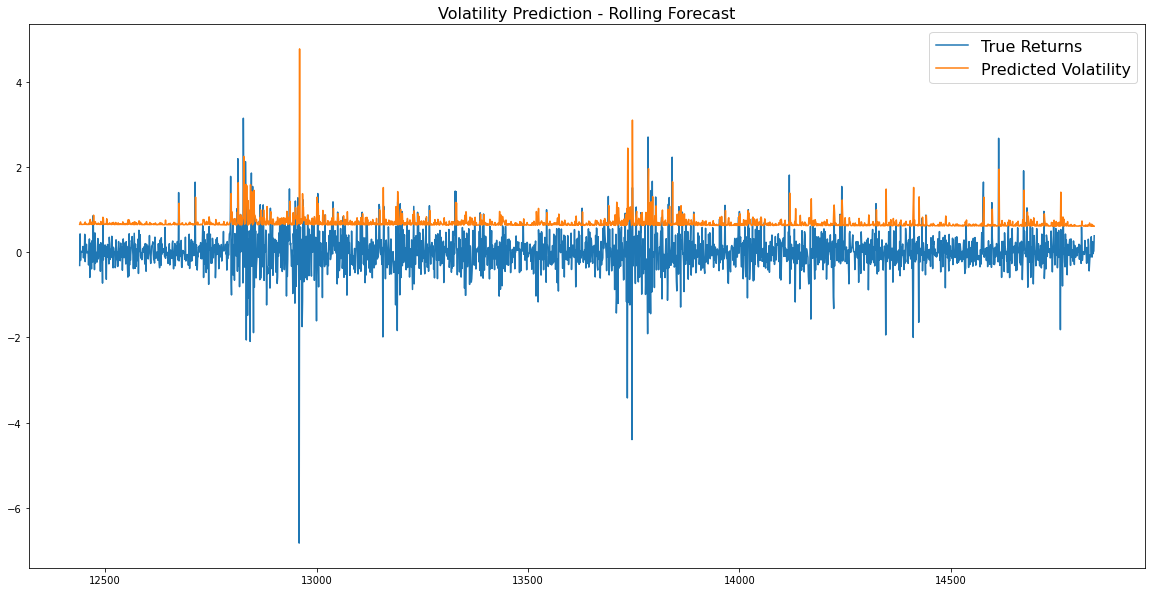

In [25]:
plt.figure(figsize=(20,10))
plt.plot(returns[-2400:])
plt.plot(rolling_predictions)
plt.title('Volatility Prediction - Rolling Forecast', fontsize=16)
plt.legend(['True Returns', 'Predicted Volatility'], fontsize=16);

## Usibility of the GARCH model


In [26]:
# we can use the predicted volatility to make judgement if we should buy or sell a bitcoin: if it's going to be very volatile in a certain period.
train = returns
btc_aud_model = arch_model(train, p=1, q=0)
btc_aud_model_fit = btc_aud_model.fit(disp='off')


In [27]:
pred = btc_aud_model_fit.forecast(horizon=10)
future_dates = [timedelta(days=i) for i in range(1,11)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

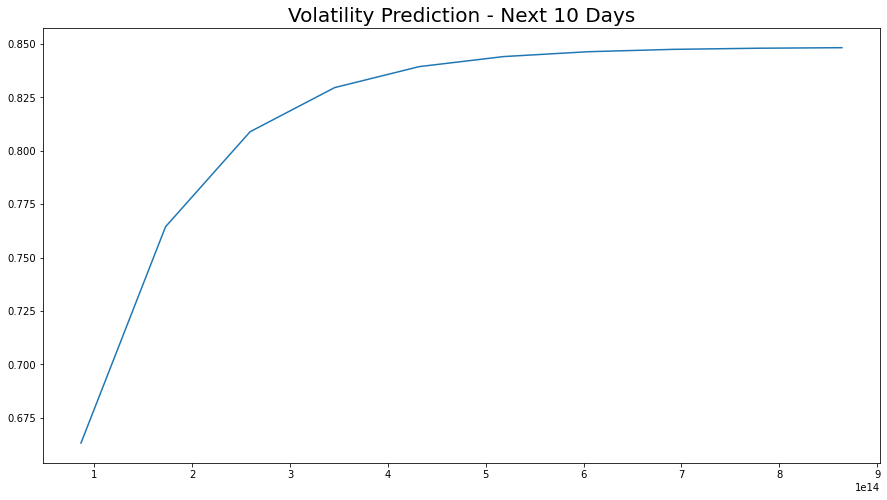

In [30]:
plt.figure(figsize=(15,8))
plt.plot(pred)
plt.title('Volatility Prediction - Next 10 Days', fontsize=20);